In [1]:
import numpy as np
from matplotlib import pyplot as plt

import time
import datetime
from config import *
from datetime import timedelta
from binance.client import Client
from BinanceFuturesPy.futurespy import Client as cf

In [2]:
client = Client(api_key, api_secret)
clientf = cf(api_key, api_secret)# , testnet=True)

In [3]:
clientf.change_leverage(2)

{'symbol': 'BTCUSDT', 'leverage': 2, 'maxNotionalValue': '300000000'}

In [ ]:
def depth_book(depth):
    bid = np.array(depth['bids']).astype(np.float64)
    bid_sum = bid.sum(axis=0) # t_value | orders

    ask = np.array(depth['asks']).astype(np.float64)
    ask_sum = ask.sum(axis=0) # t_value | orders
    
    b_price = bid[:, 0][0]
    a_price = ask[:, 0][0]
    price = (b_price+a_price)/2
    
    # bid ask price histograms
    bid_hist = np.histogram(bid[:, 0])
    ask_hist = np.histogram(ask[:, 0])
    
    # total volumen
    vol_bid = bid_sum[0]*bid_sum[1]
    vol_ask = ask_sum[0]*ask_sum[1]
    vol_total = vol_bid+vol_ask # total vol
    diff_vol = vol_bid-vol_ask # direction
    
    # porcentaje representativo
    p_bid = (vol_bid/vol_total)*100
    p_ask = (vol_ask/vol_total)*100
    p_dif = (abs(diff_vol)/vol_total)*100

    # std num orders
    std_order_bid = round(np.std(bid_hist[0]), 3)
    std_order_ask = round(np.std(ask_hist[0]), 3)
    
#     ax = plt.subplot(111)
#     ax.bar(bid[:, 0], bid[:, 1], width=0.2, color='g', align='center')
#     ax.bar(ask[:, 0], ask[:, 1], width=0.2, color='r', align='center')
#     # ax.xaxis_date()
#     plt.show()

    return std_order_bid, std_order_ask, price

In [5]:
def buy_order():
    order = clientf.new_order(
                        # symbol = 'BTCUSDT',
                        symbol = 'BTCBUSD',
                        side = 'BUY',
                        orderType = 'MARKET',
                        quantity = 1e-3,
                    )
    return order

def sell_order():
    order = clientf.new_order(
                        # symbol = 'BTCUSDT',
                        symbol = 'BTCBUSD',
                        side = 'SELL',
                        orderType = 'MARKET',
                        quantity = 1e-3,
                    )
    return order

def buy_order():
    return 1

def sell_order():
    return 0

In [ ]:
i_3 = 0
activo = 0
on = 0
on2 = 0
side = ""
lado1 = 0
lado2 = 0
diff = 0
sl = []
record = []

acc = 0
acc2 = 0

b, a = 0, 0

while True:
    # print(b, a, diff, acc, acc2, end=' ')
    t = "{} {:.1f} {:.1f} {:.1f} {} {:.3f} {:.3f}".format(i_3, b, a, diff, side, acc, acc2)
    print(t, end=" ")
    time.sleep(2)
    # price = client.futures_ticker(symbol='BTCUSDT')['lastPrice']
    try:
        # price = 48327.6
        depth = client.futures_coin_order_book(symbol='BTCUSD_PERP', pair="BTCBUSD")
        # price = client.futures_coin_mark_price(symbol='BTCUSD_PERP')
        b, a, price = depth_book(depth)
        
        diff = abs(b-a)
        if diff>=5 and on==0:
            i_3+=1
        elif diff>=6 and on==1:
            i_3+=1
        else:
            i_3=0
        
        if i_3>=4 and activo==0:
            activo=1
        
        if b>a:
            lado2 = 1
        elif a>b:
            lado2 = -1
            
        ### 1~
        if activo==1 and on==0:
            if b>a:
                ### venta
                order = sell_order()
                side = "sell"
                lado1 = 1
            elif a>b:
                ### compra
                order = buy_order()
                side = 'buy'
                lado1 = -1
            on=1
            print("open")
        elif activo==0 and on==1 and side!="":
            if side=="sell":
                order = buy_order()
            else:
                order = sell_order()
            i_3 = 0
            activo = 0
            on = 0
            side = ''
            sl = []
            record = []
            print("close 1")
        
        elif activo==1 and on==1 and lado1!=lado2 and side!="":
            if side=="sell":
                order = buy_order()
            elif side=="buy":
                order = sell_order()
            i_3 = 0
            activo = 0
            on = 0
            side = ''
            sl = []
            record = []
            print("close 2")
            
        ### 1.5
        if on==1:
#             on2+=1
#             if on2>=1:
            record.append(price)
            
        ### 2        
        if len(record)>1:
            acc = (record[-1]-record[-2])/2
        else:
            acc = 0
        
        if acc>0:
            acc2 = acc*.57
            sl.append(acc2)
        elif acc<0:
            acc2 = acc*.60
            sl.append(acc2)
        if len(sl)>0:
            if side=='buy':
                stop = max(sl)
                if acc<stop:
                    order = sell_order()
                    i_3 = 0
                    activo = 0
                    on = 0
                    side = ""
                    sl = []
                    record = []
                    print("close 3")
            elif side=="sell":
                stop = min(sl)
                if acc<stop:
                    order = buy_order()
                    i_3 = 0
                    activo = 0
                    on = 0
                    side = ""
                    sl = []
                    record = []
                    print("close 4")
                    
        elif acc<-.4 and side=='buy':
            order = sell_order()
            i_3 = 0
            activo = 0
            on = 0
            side = ""
            sl = []
            record = []
            print("close 5")
                
        elif acc>.4 and side=='sell':
            order = buy_order()
            i_3 = 0
            activo = 0
            on = 0
            side = ""
            sl = []
            record = []
            print("close 6")
        
    # except requests.exceptions.ConnectTimeout:
    except:
        #print(".", end=" ")
        print("timeout")
        # pass
        if activo==1 and on==1:
            if side=="sell":
                order = buy_order()
            elif side=="buy":
                order = sell_order()
            else:
                pass
            i_3 = 0
            activo = 0
            on = 0
            side = ''
            sl = []
            record = []
            print("close 7")
        time.sleep(15)
    # time.sleep(60)
    # i_3, activo, on, side, acc, diff
    
    # i_3, b, a, diff, side, acc, acc2
    print()

0 0.0 0.0 0.0  0.000 0.000 
1 13.9 26.0 12.1  0.000 0.000 
2 12.9 25.3 12.4  0.000 0.000 
3 13.4 24.8 11.4  0.000 0.000 
0 16.9 19.5 2.7  0.000 0.000 
0 16.7 18.6 1.9  0.000 0.000 
0 16.0 19.3 3.3  0.000 0.000 
1 17.0 22.7 5.7  0.000 0.000 
0 16.3 19.9 3.7  0.000 0.000 
0 16.4 19.9 3.5  0.000 0.000 
1 16.5 21.9 5.4  0.000 0.000 
2 16.3 21.4 5.0  0.000 0.000 
0 16.7 21.3 4.6  0.000 0.000 
0 16.5 18.6 2.1  0.000 0.000 
0 16.2 18.6 2.4  0.000 0.000 
1 18.1 24.3 6.2  0.000 0.000 
0 16.5 18.7 2.2  0.000 0.000 
0 16.5 18.4 1.9  0.000 0.000 
0 15.5 19.4 3.9  0.000 0.000 
0 16.4 17.5 1.2  0.000 0.000 
0 15.3 18.0 2.6  0.000 0.000 
0 15.6 17.7 2.1  0.000 0.000 
0 14.9 17.6 2.7  0.000 0.000 
0 16.1 17.4 1.2  0.000 0.000 
0 15.7 18.3 2.6  0.000 0.000 
0 14.0 18.4 4.4  0.000 0.000 
0 14.3 19.0 4.7  0.000 0.000 
1 12.6 18.7 6.0  0.000 0.000 
2 22.5 13.7 8.9  0.000 0.000 
3 13.3 19.2 5.9  0.000 0.000 
0 13.9 18.9 5.0  0.000 0.000 
1 11.2 23.4 12.2  0.000 0.000 
2 11.7 24.1 12.5  0.000 0.000 
3 9.5 2

0 19.5 21.4 1.9  0.000 -1.440 
0 19.4 21.9 2.5  0.000 -1.440 
0 17.9 22.1 4.2  0.000 -1.440 
0 18.0 22.0 4.0  0.000 -1.440 
0 18.6 21.8 3.2  0.000 -1.440 
0 18.7 22.6 3.9  0.000 -1.440 
0 18.4 22.8 4.4  0.000 -1.440 
1 19.4 29.1 9.7  0.000 -1.440 
2 20.0 28.8 8.8  0.000 -1.440 
3 19.2 27.9 8.6  0.000 -1.440 open

4 20.5 27.4 6.9 buy 0.000 -1.440 
5 19.4 27.2 7.8 buy 0.000 -1.440 close 3

0 20.2 27.8 7.6  -1.450 -0.870 
1 19.0 27.1 8.1  0.000 -0.870 
0 20.1 24.8 4.7  0.000 -0.870 
0 20.1 24.4 4.3  0.000 -0.870 
1 20.2 25.9 5.7  0.000 -0.870 
0 20.2 25.0 4.8  0.000 -0.870 
0 21.0 25.4 4.5  0.000 -0.870 
0 19.6 24.4 4.8  0.000 -0.870 
1 22.3 27.7 5.5  0.000 -0.870 
2 19.3 24.4 5.1  0.000 -0.870 
3 19.5 24.5 5.0  0.000 -0.870 
0 20.0 24.6 4.6  0.000 -0.870 
0 19.9 24.6 4.7  0.000 -0.870 
0 20.2 24.7 4.6  0.000 -0.870 
0 19.7 23.7 4.0  0.000 -0.870 
0 20.3 24.1 3.9  0.000 -0.870 
0 19.6 23.7 4.1  0.000 -0.870 
0 20.3 22.3 2.0  0.000 -0.870 
0 20.3 23.0 2.8  0.000 -0.870 
0 20.2 23.0 2.7  0.

In [ ]:
### 1. testear 2 confirmaciones
### 2. testear invertir estrategia

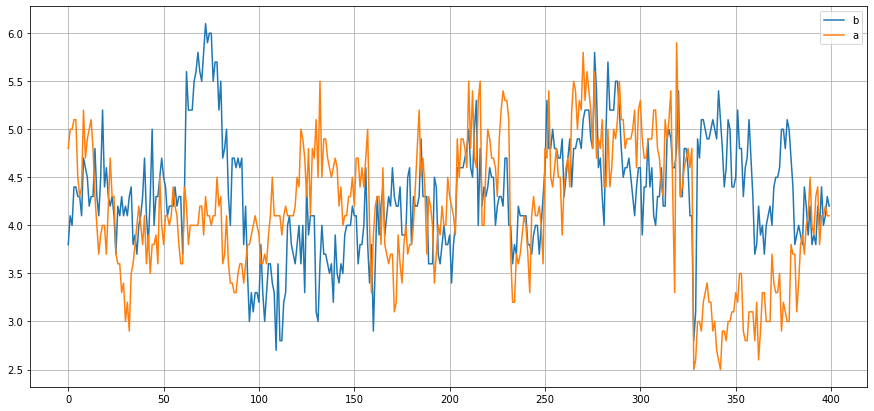

In [31]:
t = T[-400:, :]
plt.figure(figsize=(15, 7))
plt.plot(t[:, 0])
plt.plot(t[:, 1])
plt.legend(['b', 'a'])
plt.grid()